# Dissolve

In [ ]:
import geopandas
import starepandas
import numpy
import pystare
import matplotlib.pyplot as plt
import datetime
from shapely.wkt import loads

In [ ]:
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = {
    'pop_est': [37589262.0, 328239523.0, 11263077.0, 10738958.0,
                389482.0, 56225.0, 127575529.0, 4246439.0,
                5047561.0, 6545502.0, 9746117.0, 6453553.0,
                16604026.0, 390353.0, 3193694.0, 2948279.0,
                11333483.0, 1394973.0],
    'continent': ['North America', 'North America', 'North America', 'North America', 
                  'North America', 'North America', 'North America', 'North America', 
                  'North America', 'North America', 'North America', 'North America', 
                  'North America', 'North America'],
    'name': ['Canada', 'United States of America', 'Haiti', 'Dominican Rep.', 
             'Bahamas', 'Greenland', 'Mexico', 'Panama',
             'Costa Rica', 'Nicaragua', 'Honduras', 'El Salvador',
             'Guatemala', 'Belize', 'Puerto Rico', 'Jamaica',
             'Cuba', 'Trinidad and Tobago'],
    'iso_a3': ['CAN', 'USA', 'HTI', 'DOM',
               'BHS', 'GRL', 'MEX', 'PAN',
               'CRI', 'NIC', 'HND', 'SLV',
               'GTM', 'BLZ', 'PRI', 'JAM',
               'CUB', 'TTO'],
    'gdp_md_est': [1736425, 21433226, 14332, 88941,
                   13578, 3051, 1268870, 66800,
                   61801, 12520, 25095, 27022,
                   76710, 1879, 104988, 16458,
                   100023, 24269],
    'geometry': [
        # Canada
        "MULTIPOLYGON (((-122.84 49.00000000000011, -122.97421 49.00253777777778, -124.91024 49.98456, -125.62461 50.41656, -127.43561 50.83061, -127.99276 51.71583, -127.85032 52.32961, -129.12979 52.75538, -129.30523 53.56159, -130.51497 54.28757, -130.5361089527368 54.80275447679924, -130.53611 54.80278000000001, -129.98 55.285, -130.00778 55.91583000000008, -131.70781 56.55212, -132.73042 57.69289000000001, -133.35556 58.41028000000001, -134.27111 58.86111000000005, -134.9450000000001 59.2705600000001, -135.47583 59.78778000000001, -136.47972 59.46389000000005, -137.4525 58.905, -138.34089 59.56211, -139.039 60, -140.013 60.27682000000001, -140.99778 60.30639000000001, -140.9925 66.00003000000001, -140.986 69.712, -140.985987610376 69.71199839952635, -139.12052 69.47102, -137.54636 68.99002, -136.50358 68.89803999999999, -135.62576 69.31512000000001, -134.41464 69.62743, -132.92925 69.50534, -131.43136 69.94450999999999, -129.79471 70.19369, -129.10773 69.77927000000001, -128.36156 70.01286, -128.13817 70.48384, -127.44712 70.37721000000001, -125.75632 69.48058, -124.42483 70.1584, -124.28968 69.39968999999999, -123.06108 69.56372, -122.6835 69.85553, -121.47226 69.79778, -119.94288 69.37786, -117.60268 69.01128, -116.22643 68.84151, -115.2469 68.90591000000001, -113.89794 68.3989, -115.30489 67.90261000000001, -113.49727 67.68815000000001, -110.798 67.80611999999999, -109.94619 67.98104000000001, -108.8802 67.38144, -107.79239 67.88736, -108.81299 68.31164, -108.16721 68.65392, -106.95 68.7, -106.15 68.8, -105.34282 68.56122000000001, -104.33791 68.018, -103.22115 68.09775, -101.45433 67.64689, -99.90195 67.80566, -98.4432 67.78165, -98.5586 68.40394000000001, -97.66948000000001 68.57864000000001, -96.11991 68.23939, -96.12588 67.29338, -95.48943 68.0907, -94.685 68.06383, -94.23282000000002 69.06903000000001, -95.30408 69.68571, -96.47131 70.08976, -96.39115 71.19482000000001, -95.2088 71.92053, -93.88997000000001 71.76015, -92.87818 71.31869, -91.51964000000001 70.19129000000001, -92.40692000000001 69.69997000000001, -90.5471 69.49766, -90.55151000000001 68.47499000000001, -89.21514999999999 69.25873, -88.01966 68.61508000000001, -88.31748999999999 67.87338000000001, -87.35017000000001 67.19871999999999, -86.30606999999999 67.92146, -85.57664 68.78456, -85.52197 69.88211, -84.10081000000001 69.80539, -82.62258 69.65826, -81.28043000000001 69.16202000000001, -81.22019999999999 68.66567000000001, -81.96436000000001 68.13253, -81.25928 67.59716, -81.38653000000001 67.11078000000001, -83.34456 66.41154, -84.73542 66.2573, -85.76943 66.55833, -86.06760000000001 66.05625000000001, -87.03143 65.21297, -87.32324 64.77563000000001, -88.48296000000001 64.09897000000001, -89.91444 64.03273, -90.70398 63.61017, -90.77004000000001 62.96021, -91.93342 62.83508, -93.15698 62.02469000000001, -94.24153 60.89865, -94.62930999999999 60.11021, -94.6846 58.94882, -93.21502000000001 58.78212, -92.76462000000001 57.84571, -92.29702999999999 57.08709, -90.89769 57.28468, -89.03953 56.85172, -88.03978000000001 56.47162, -87.32420999999999 55.99914, -86.07120999999999 55.72383, -85.01181000000001 55.30260000000001, -83.36055 55.24489, -82.27285000000001 55.14832, -82.43620000000001 54.28227, -82.12502000000001 53.27703, -81.40075 52.15788000000001, -79.91289 51.20842, -79.14301 51.53393000000001, -78.60191 52.56208, -79.12421000000001 54.14145, -79.82958000000001 54.66772, -78.22874 55.13645, -77.0956 55.83741, -76.54137 56.53423000000001, -76.62319000000001 57.20263, -77.30226 58.05209, -78.51688 58.80458, -77.33676 59.85261000000001, -77.77272000000001 60.75788000000001, -78.10687 62.31964000000001, -77.41067 62.55053, -75.69621000000001 62.2784, -74.6682 62.18111, -73.83988000000001 62.4438, -72.90853 62.10507, -71.67708 61.52535, -71.37369000000001 61.13717, -69.59041999999999 61.06141, -69.62033 60.22125, -69.28790000000001 58.95736, -68.37455 58.80106, -67.64976 58.21206, -66.20178 58.76731, -65.24517 59.87071, -64.58352000000001 60.33558, -63.80475000000001 59.44260000000001, -62.50236 58.16708, -61.39655 56.96745000000001, -61.79866000000001 56.33945, -60.46853 55.77547999999999, -59.56962 55.20407, -57.97508 54.94549000000001, -57.3332 54.6265, -56.93689 53.78032, -56.15811 53.64749, -55.75632 53.27036, -55.68338 52.14664, -56.40916000000001 51.77070000000001, -57.12691 51.41972000000001, -58.77482 51.0643, -60.03309000000001 50.24277, -61.72366 50.08046, -63.86251 50.29099, -65.36331 50.2982, -66.39905 50.22897, -67.23631 49.51156, -68.51114 49.06836000000001, -69.95362 47.74488, -71.10458 46.82171, -70.25521999999999 46.98605999999999, -68.65000000000001 48.3, -66.55243 49.1331, -65.05625999999999 49.23278000000001, -64.17099 48.74248, -65.11545000000001 48.07085, -64.79854 46.99297, -64.47219 46.23849000000001, -63.17329000000001 45.73902, -61.52072 45.88377000000001, -60.51815000000001 47.00793, -60.44860000000001 46.28264, -59.80287 45.9204, -61.03988 45.26524999999999, -63.25471 44.67014, -64.24656 44.26553000000001, -65.36406000000001 43.54523, -66.1234 43.61867, -66.16173000000001 44.46512, -64.42549 45.29204, -66.02605000000001 45.25931, -67.13741 45.13753, -67.79134000000001 45.70281000000001, -67.79046000000001 47.06636, -68.23444000000001 47.35485999999997, -68.90500000000003 47.18500000000006, -69.237216 47.447781, -69.99997 46.69307, -70.30500000000001 45.915, -70.66 45.46, -71.08482000000004 45.30524000000014, -71.405 45.255, -71.50506 45.0082, -73.34783 45.00738, -74.86700000000002 45.0004800000001, -75.31821000000001 44.81645, -76.375 44.09631, -76.50000000000001 44.01845889375865, -76.82003414580558 43.62878428809375, -77.7378850979577 43.62905558936328, -78.72027991404235 43.62508942318493, -79.17167355011186 43.46633942318426, -79.01000000000001 43.27, -78.92 42.965, -78.93936214874375 42.86361135514798, -80.24744767934794 42.36619985612255, -81.27774654816716 42.20902598730682, -82.43927771679159 41.67510508886733, -82.69008928092023 41.67510508886733, -83.02981014680699 41.83279572200598, -83.14199968131264 41.97568105729287, -83.12 42.08, -82.90000000000001 42.43, -82.42999999999999 42.98, -82.13764238150395 43.57108755143997, -82.33776312543114 44.44000000000005, -82.55092464875821 45.34751658790543, -83.59285071484311 45.81689362241252, -83.46955074739469 45.99468638771253, -83.61613094759059 46.11692698829901, -83.89076534700574 46.11692698829901, -84.09185126416151 46.27541860613826, -84.14211951367341 46.51222585711571, -84.33670000000001 46.40877, -84.60490000000004 46.43959999999998, -84.54374874544584 46.53868419044915, -84.77923824739992 46.63710195574902, -84.8760798815149 46.90008331968238, -85.65236324740341 47.22021881773051, -86.46199083122826 47.553338019392, -87.43979262330028 47.94, -88.37811418328671 48.30291758889371, -89.27291744663665 48.01980825458281, -89.60000000000002 48.0100000000001, -90.83 48.27, -91.64 48.14, -92.61000000000001 48.44999999999993, -93.63087000000002 48.60926000000001, -94.32914000000001 48.67074, -94.64 48.84, -94.81758000000002 49.38905, -95.15609000000001 49.38425000000001, -95.15906950917206 49, -97.2287200000048 49.0007, -100.65 49.00000000000011, -104.04826 48.99986000000007, -107.05 49, -110.05 49, -113 49, -116.04818 49, -117.03121 49, -120 49.00000000000011, -122.84 49.00000000000011)), ((-83.99367000000001 62.4528, -83.25048 62.91409, -81.87699000000001 62.90458, -81.89825 62.7108, -83.06857000000001 62.15922, -83.77462000000001 62.18231, -83.99367000000001 62.4528)), ((-79.77583312988281 72.8029022216797, -80.87609863281251 73.33318328857422, -80.83388519287111 73.69318389892578, -80.35305786132812 73.75971984863281, -78.06443786621094 73.65193176269531, -76.34 73.10268498995305, -76.25140380859375 72.82638549804688, -77.31443786621094 72.85554504394531, -78.39167022705078 72.87665557861328, -79.4862518310547 72.74220275878906, -79.77583312988281 72.8029022216797)), ((-80.315395 62.08556500000001, -79.92939 62.3856, -79.52002 62.36371, -79.26582000000001 62.158675, -79.65752000000001 61.63308, -80.09956000000001 61.71810000000001, -80.36215 62.01649, -80.315395 62.08556500000001)), ((-93.61275590694046 74.97999726022438, -94.15690873897391 74.59234650338688, -95.60868058956564 74.66686391875176, -96.82093217648455 74.92762319609658, -96.28858740922982 75.37782827422338, -94.85081987178917 75.64721751576089, -93.97774654821797 75.29648956979595, -93.61275590694046 74.97999726022438)), ((-93.84000301794399 77.51999726023455, -94.29560828324529 77.49134267852868, -96.16965410031007 77.55511139597685, -96.43630449093614 77.83462921824362, -94.42257727738641 77.82000478790501, -93.7206562975659 77.63433136668031, -93.84000301794399 77.51999726023455)), ((-96.75439876990876 78.76581268992702, -95.5592779202946 78.41831452098033, -95.83029496944934 78.05694122996324, -97.30984290239799 77.85059723582181, -98.12428931353404 78.08285696075761, -98.55286780474668 78.45810537384507, -98.63198442258553 78.87193024363837, -97.33723141151266 78.83198436147676, -96.75439876990876 78.76581268992702)), ((-88.15035030796028 74.39230703398503, -89.7647220527584 74.51555532500116, -92.42244096552946 74.83775788034099, -92.76828548864282 75.38681997344214, -92.88990597204175 75.88265534128267, -93.89382402217599 76.31924367950056, -95.9624574450358 76.4413809272224, -97.12137895382951 76.7510777859476, -96.74512285031237 77.16138865834507, -94.68408586299944 77.09787832305837, -93.57392106807313 76.77629588490605, -91.6050231595366 76.77851797149459, -90.74184587274929 76.44959747995681, -90.96966142450802 76.07401317005947, -89.82223792189926 75.84777374948565, -89.18708289259985 75.61016551380762, -87.83827633334965 75.56618886992725, -86.37919226758864 75.48242137318211, -84.78962521029058 75.69920400664653, -82.75344458691006 75.78431509063124, -81.12853084992436 75.71398346628199, -80.05751095245915 75.33684886341591, -79.83393286814837 74.92312734648716, -80.45777075877587 74.65730377877777, -81.94884253612557 74.44245901152432, -83.22889360221143 74.56402781849094, -86.09745235873332 74.41003205026117, -88.15035030796028 74.39230703398503)), ((-111.2644433256309 78.15295604116154, -109.8544518705471 77.99632477488488, -110.186938035913 77.69701487905034, -112.0511911690585 77.4092288276169, -113.5342789376191 77.73220652944111, -112.7245867582539 78.05105011668196, -111.2644433256309 78.15295604116154)), ((-110.963660651476 78.80444082306521, -109.6631457182026 78.60197256134565, -110.8813142566189 78.40691986765997, -112.5420914376152 78.40790171987349, -112.5258908760916 78.55055451121522, -111.5000103422334 78.8499935981305, -110.963660651476 78.80444082306521)), ((-55.60021826844206 51.31707469339794, -56.13403581401709 50.68700979267928, -56.79588172059528 49.81230866149089, -56.14310502788433 50.15011749938286, -55.471492275603 49.93581533466846, -55.82240108908096 49.58712860777905, -54.93514258484564 49.3130109726868, -54.47377539734379 49.55669118915912, -53.47654944519137 49.24913890237404, -53.78601375997125 48.51678050393362, -53.08613399922626 48.68780365660358, -52.95864824076222 48.15716421161447, -52.64809872090421 47.53554840757552, -53.06915829121839 46.65549876564492, -53.521456264853 46.61829173439477, -54.17893551290251 46.80706574155698, -53.9618686590605 47.62520701760193, -54.24048214376214 47.75227936460765, -55.40077307801157 46.88499380145313, -55.99748084168583 46.91972036395327, -55.29121904155279 47.38956248635099, -56.25079871278059 47.63254507098738, -57.32522925477708 47.57280711525797, -59.26601518414682 47.60334788674247, -59.41949418805368 47.89945384377489, -58.79658647320744 48.25152537697942, -59.23162451845657 48.52318838153781, -58.3918049790652 49.12558055276418, -57.35868974468606 50.71827403421587, -56.73865007183203 51.28743825947855, -55.87097693543532 51.63209422464921, -55.40697424988659 51.5882726100657, -55.60021826844206 51.31707469339794)), ((-83.88262630891977 65.10961782496354, -82.78757687043883 64.76669302027467, -81.64201371939259 64.45513580998697, -81.55344031444432 63.97960928003714, -80.81736121287886 64.057485663501, -80.10345130076664 63.72598135034862, -80.99101986359572 63.41124603947496, -82.54717810741704 63.65172231714521, -83.10879757356511 64.10187571883971, -84.10041663281388 63.569711819098, -85.52340471061905 63.05237905542405, -85.8667687649824 63.63725291610349, -87.22198320183678 63.54123810490519, -86.35275977247133 64.0358332383707, -86.2248864407651 64.82291697860823, -85.88384782585486 65.7387783881171, -85.16130794954989 65.6572846543928, -84.97576371940592 65.21751821558898, -84.46401201041949 65.37177236598022, -83.88262630891977 65.10961782496354)), ((-78.77063859731078 72.35217316353418, -77.8246239895596 72.74961660429098, -75.60584469267573 72.2436784939374, -74.228616095665 71.76714427355789, -74.09914079455771 71.33084015571758, -72.24222571479768 71.55692454699452, -71.20001542833518 70.92001251899718, -68.7860542466849 70.52502370877427, -67.91497046575694 70.12194753689765, -66.9690333726542 69.18608734809182, -68.8051228502006 68.72019847276444, -66.44986609563389 68.06716339789203, -64.86231441919524 67.84753856065159, -63.42493445499679 66.92847321234059, -61.8519813706806 66.86212067327783, -62.16317684594226 66.16025136988962, -63.91844438338418 64.99866852483289, -65.14886023625368 65.42603261988667, -66.72121904159852 66.38804108343219, -68.01501603867401 66.26272573512439, -68.14128740097919 65.68978913030439, -67.08964616562342 65.10845510523696, -65.73208045109976 64.64840566675856, -65.32016760930125 64.38273712834605, -64.66940629744968 63.39292674422749, -65.01380388045888 62.67418508569598, -66.27504472519048 62.94509878198612, -68.7831862046927 63.74567007105183, -67.36968075221309 62.88396556258484, -66.32829728866726 62.28007477482201, -66.16556820338015 61.93089712182582, -68.87736650254465 62.33014923771282, -71.02343705919385 62.91070811629588, -72.23537858751902 63.39783600529522, -71.88627844917127 63.67998932560887, -73.37830624051838 64.19396312118384, -74.83441891142263 64.6790756293238, -74.81850257027673 64.38909332951793, -77.70997982452008 64.22954234481678, -78.5559488593542 64.57290639918013, -77.89728105336198 65.30919220647475, -76.01827429879717 65.32696889918314, -73.95979529488268 65.45476471624094, -74.29388342964964 65.81177134872938, -73.94491248238262 66.31057811142666, -72.65116716173942 67.28457550726391, -72.92605994331605 67.72692576768235, -73.31161780464572 68.06943716091287, -74.84330725777684 68.55462718370127, -76.86910091826672 68.89473562283025, -76.22864905465738 69.14776927354741, -77.28736996123715 69.76954010688321, -78.1686339993266 69.82648753526887, -78.95724219431673 70.16688019477543, -79.49245500356366 69.87180776638884, -81.30547095409176 69.74318512641436, -84.94470618359851 69.96663401964442, -87.06000342481789 70.26000112576538, -88.68171322300148 70.4107412787608, -89.51341956252303 70.76203766548095, -88.46772111688082 71.21818553332132, -89.88815121128755 71.22255219184997, -90.20516028518205 72.23507436796079, -89.436576707705 73.12946421985238, -88.40824154331287 73.53788890247121, -85.82615108920098 73.80381582304518, -86.56217851433412 73.15744700793844, -85.77437130404454 72.53412588163387, -84.85011247428822 73.34027822538708, -82.31559017610101 73.7509508328106, -80.60008765330768 72.71654368762417, -80.74894161652443 72.06190664335072, -78.77063859731078 72.35217316353418)), ((-94.50365759965237 74.13490672473922, -92.42001217321173 74.10002513294221, -90.50979285354263 73.85673248971206, -92.00396521682987 72.96624420845852, -93.19629553910026 72.77199249947334, -94.26904659704726 72.02459625923599, -95.40985551632266 72.06188080513458, -96.03374508338244 72.94027680123183, -96.01826799191102 73.43742991809582, -95.49579342322404 73.86241689726417, -94.50365759965237 74.13490672473922)), ((-122.854924486159 76.11654287383568, -122.8549252936033 76.11654287383568, -121.1575353603282 76.86450755482828, -119.1039389718211 77.51221995717462, -117.570130784966 77.4983189968881, -116.1985865955074 77.64528677032619, -116.3358133614584 76.87696157501061, -117.1060505847688 76.53003184681911, -118.0404121570382 76.48117178008714, -119.8993175868857 76.053213406062, -121.4999950771265 75.90001862253276, -122.854924486159 76.11654287383568)), ((-132.7100078844313 54.04000931542356, -131.7499895840033 54.12000438090922, -132.049480347351 52.98462148702447, -131.1790425218266 52.18043284769828, -131.577829549823 52.18237071390928, -132.1804284267785 52.6397071396924, -132.5499924323138 53.10001496033215, -133.0546111787555 53.41146881775541, -133.2396644827927 53.85108022726234, -133.1800040417117 54.16997549093531, -132.7100078844313 54.04000931542356)), ((-105.4922891914932 79.30159393992916, -103.5292823962379 79.16534902619163, -100.8251580472688 78.80046173777872, -100.0601918200522 78.32475434031589, -99.67093909381364 77.90754466420744, -101.303940192453 78.01898489044486, -102.949808722733 78.34322866486023, -105.1761327787315 78.3803323432458, -104.2104294502771 78.67742015249176, -105.4195804512585 78.91833567983649, -105.4922891914932 79.30159393992916)), ((-123.5100015875512 48.51001089130341, -124.0128907883995 48.37084625914139, -125.6550127773384 48.8250045843385, -125.9549944667928 49.17999583596759, -126.8500044358719 49.53000031188043, -127.0299934495444 49.81499583597008, -128.0593363043662 49.9949590114266, -128.4445841071021 50.5391376816761, -128.3584136562555 50.77064809834371, -127.3085810960299 50.55257355407196, -126.6950009772123 50.40090322529539, -125.7550066738232 50.29501821552935, -125.4150015875588 49.95000051533259, -124.9207681891193 49.47527497008338, -123.9225087083211 49.06248362893581, -123.5100015875512 48.51001089130341)), ((-121.53788 74.44893000000002, -120.10978 74.24135000000001, -117.5556399999999 74.18576999999993, -116.58442 73.89607000000007, -115.51081 73.47519, -116.76794 73.22291999999999, -119.22 72.51999999999998, -120.46 71.82000000000005, -120.46 71.38360179308756, -123.09219 70.90164000000004, -123.62 71.34000000000009, -125.9289487374734 71.86868846301138, -125.4999999999999 72.29226081179502, -124.80729 73.02255999999994, -123.9399999999999 73.68000000000012, -124.91775 74.29275000000013, -121.53788 74.44893000000002)), ((-107.81943 75.84552000000001, -106.92893 76.01282, -105.881 75.96940000000001, -105.70498 75.47951, -106.31347 75.00527, -109.7 74.85000000000001, -112.22307 74.41696, -113.74381 74.39427000000001, -113.87135 74.72029000000001, -111.79421 75.16250000000001, -116.31221 75.04343, -117.7104 75.2222, -116.34602 76.19903000000001, -115.40487 76.47887, -112.59056 76.14134, -110.81422 75.54919, -109.0671 75.47321000000001, -110.49726 76.42982000000001, -109.5811 76.79416999999999, -108.54859 76.67832000000001, -108.21141 76.20168000000001, -107.81943 75.84552000000001)), ((-106.5225899999999 73.07601, -105.40246 72.67259000000007, -104.77484 71.69840000000011, -104.4647599999999 70.99297000000007, -102.78537 70.49776000000003, -100.9807799999999 70.02431999999999, -101.0892899999999 69.58447000000012, -102.7311599999999 69.50402000000003, -102.09329 69.11962000000011, -102.43024 68.75281999999999, -104.24 68.91000000000008, -105.96 69.18000000000012, -107.12254 69.11922000000004, -108.9999999999999 68.78000000000003, -111.5341488752002 68.63005915681794, -113.3132000000001 68.53553999999997, -113.8549599999999 69.00744000000009, -115.22 69.28000000000009, -116.10794 69.16821000000004, -117.34 69.96000000000009, -116.67473 70.06655000000001, -115.13112 70.23730000000006, -113.72141 70.1923700000001, -112.4161 70.36637999999999, -114.35 70.60000000000002, -116.48684 70.52044999999998, -117.9048 70.54056000000014, -118.43238 70.90920000000006, -116.11311 71.30917999999997, -117.65568 71.29520000000002, -119.40199 71.55858999999998, -118.56267 72.30785000000003, -117.8664199999999 72.70594000000006, -115.18909 73.31459000000012, -114.1671699999999 73.1214500000001, -114.66634 72.65277000000009, -112.4410199999999 72.95540000000011, -111.05039 72.45040000000006, -109.9203499999999 72.96113000000008, -109.00654 72.63335000000001, -108.18835 71.65089, -107.68599 72.06548000000009, -108.39639 73.08953000000008, -107.51645 73.23597999999998, -106.5225899999999 73.07601)), ((-100.43836 72.70588000000001, -101.54 73.36, -100.35642 73.84389, -99.16387 73.63339000000001, -97.38 73.76000000000001, -97.12 73.47, -98.05359 72.99052, -96.54000000000001 72.56, -96.72000000000001 71.66, -98.35966000000001 71.27284999999999, -99.32286000000001 71.35639, -100.01482 71.73827, -102.5 72.51000000000001, -102.48 72.83000000000001, -100.43836 72.70588000000001)), ((-106.6 73.60000000000001, -105.26 73.64, -104.5 73.42, -105.38 72.76000000000001, -106.94 73.46000000000001, -106.6 73.60000000000001)), ((-98.50000000000001 76.72, -97.735585 76.25656000000001, -97.70441500000001 75.74344000000001, -98.16000000000001 75, -99.80874 74.89744, -100.88366 75.05736, -100.86292 75.64075, -102.50209 75.5638, -102.56552 76.3366, -101.48973 76.30537, -99.98349 76.64634, -98.57699 76.58859, -98.50000000000001 76.72)), ((-96.01644 80.60233000000001, -95.32345000000001 80.90729, -94.29843 80.97727, -94.73542 81.20646000000002, -92.40983999999999 81.25739000000003, -91.13288999999999 80.72345000000003, -89.45000000000002 80.50932203389831, -87.81 80.32000000000001, -87.02000000000001 79.66000000000001, -85.81435 79.3369, -87.18755999999999 79.0393, -89.03535000000001 78.28722999999999, -90.80436 78.21533000000001, -92.87669000000001 78.34333000000001, -93.95116000000002 78.75099, -93.93574 79.11373, -93.14524 79.3801, -94.974 79.37248, -96.07614000000001 79.70502, -96.70972 80.15777, -96.01644 80.60233000000001)), ((-91.58702000000001 81.89429000000001, -90.10000000000001 82.08500000000004, -88.93227 82.11751000000001, -86.97024 82.27961000000001, -85.5 82.65227345805702, -84.26000500000001 82.60000000000001, -83.18000000000001 82.31999999999999, -82.42 82.86000000000001, -81.09999999999999 83.02, -79.30664 83.13056, -76.25 83.17205882352941, -75.71878000000001 83.06404000000002, -72.83153 83.23324000000001, -70.66576500000001 83.16978075838284, -68.50000000000001 83.10632151676572, -65.82735 83.02801000000001, -63.68 82.90000000000001, -61.85 82.62860000000002, -61.89388 82.36165000000001, -64.334 81.92775000000002, -66.75342000000001 81.72527000000001, -67.65755 81.50141000000001, -65.48031 81.50657000000002, -67.84 80.90000000000003, -69.4697 80.61683000000001, -71.18000000000001 79.8, -73.2428 79.63415000000001, -73.88000000000001 79.43016220480206, -76.90773 79.32309000000001, -75.52924 79.19766000000001, -76.22046 79.01907, -75.39345 78.52581000000001, -76.34354 78.18296000000001, -77.88851000000001 77.89991000000001, -78.36269 77.50859000000001, -79.75951000000001 77.20967999999999, -79.61965000000001 76.98336, -77.91089000000001 77.02204500000001, -77.88911 76.77795500000001, -80.56125 76.17812000000001, -83.17439 76.45403, -86.11184 76.29901000000001, -87.60000000000001 76.42, -89.49068 76.47239, -89.6161 76.95213000000001, -87.76739000000001 77.17833, -88.26000000000001 77.90000000000001, -87.65000000000001 77.97022222222223, -84.97633999999999 77.53873, -86.34 78.18000000000001, -87.96191999999999 78.37181, -87.15198000000001 78.75867, -85.37868 78.99690000000001, -85.09495 79.34543000000001, -86.50734 79.73624, -86.93179000000001 80.25145000000001, -84.19844000000001 80.20836, -83.40869565217389 80.10000000000001, -81.84823 80.46442, -84.09999999999999 80.58, -87.59895 80.51627000000001, -89.36663 80.85569000000001, -90.2 81.26000000000001, -91.36786000000001 81.5531, -91.58702000000001 81.89429000000001)), ((-75.21597 67.44425, -75.86588 67.14886, -76.98687 67.09873, -77.2364 67.58809000000001, -76.81166 68.14856, -75.89521000000001 68.28721, -75.11449999999999 68.01035999999999, -75.10333 67.58202, -75.21597 67.44425)), ((-96.25740120380055 69.49003035832177, -95.64768120380054 69.10769035832178, -96.26952120380055 68.75704035832177, -97.61740120380055 69.06003035832177, -98.43180120380055 68.95070035832177, -99.79740120380055 69.40003035832177, -98.91740120380055 69.71003035832177, -98.21826120380055 70.14354035832177, -97.15740120380055 69.86003035832177, -96.55740120380055 69.68003035832177, -96.25740120380055 69.49003035832177)), ((-64.51912 49.87304, -64.17322 49.95718, -62.85829 49.70641, -61.83558499999999 49.28855, -61.80630499999999 49.10506000000001, -62.29318 49.08717, -63.58926 49.40069, -64.51912 49.87304)), ((-64.01486 47.03601, -63.6645 46.55001, -62.9393 46.41587, -62.01208 46.44314, -62.50391 46.03339, -62.87433 45.96818, -64.14280000000001 46.39265, -64.39261 46.72747, -64.01486 47.03601)))",
        # USA
        "MULTIPOLYGON (((-122.84 49.00000000000011, -120 49.00000000000011, -117.03121 49, -116.04818 49, -113 49, -110.05 49, -107.05 49, -104.04826 48.99986000000007, -100.65 49.00000000000011, -97.2287200000048 49.0007, -95.15906950917206 49, -95.15609000000001 49.38425000000001, -94.81758000000002 49.38905, -94.64 48.84, -94.32914000000001 48.67074, -93.63087000000002 48.60926000000001, -92.61000000000001 48.44999999999993, -91.64 48.14, -90.83 48.27, -89.60000000000002 48.0100000000001, -89.27291744663665 48.01980825458281, -88.37811418328671 48.30291758889371, -87.43979262330028 47.94, -86.46199083122826 47.553338019392, -85.65236324740341 47.22021881773051, -84.8760798815149 46.90008331968238, -84.77923824739992 46.63710195574902, -84.54374874544584 46.53868419044915, -84.60490000000004 46.43959999999998, -84.33670000000001 46.40877, -84.14211951367341 46.51222585711571, -84.09185126416151 46.27541860613826, -83.89076534700574 46.11692698829901, -83.61613094759059 46.11692698829901, -83.46955074739469 45.99468638771253, -83.59285071484311 45.81689362241252, -82.55092464875821 45.34751658790543, -82.33776312543114 44.44000000000005, -82.13764238150395 43.57108755143997, -82.42999999999999 42.98, -82.90000000000001 42.43, -83.12 42.08, -83.14199968131264 41.97568105729287, -83.02981014680699 41.83279572200598, -82.69008928092023 41.67510508886733, -82.43927771679159 41.67510508886733, -81.27774654816716 42.20902598730682, -80.24744767934794 42.36619985612255, -78.93936214874375 42.86361135514798, -78.92 42.965, -79.01000000000001 43.27, -79.17167355011186 43.46633942318426, -78.72027991404235 43.62508942318493, -77.7378850979577 43.62905558936328, -76.82003414580558 43.62878428809375, -76.50000000000001 44.01845889375865, -76.375 44.09631, -75.31821000000001 44.81645, -74.86700000000002 45.0004800000001, -73.34783 45.00738, -71.50506 45.0082, -71.405 45.255, -71.08482000000004 45.30524000000014, -70.66 45.46, -70.30500000000001 45.915, -69.99997 46.69307, -69.237216 47.447781, -68.90500000000003 47.18500000000006, -68.23444000000001 47.35485999999997, -67.79046000000001 47.06636, -67.79134000000001 45.70281000000001, -67.13741 45.13753, -66.96465999999998 44.80970000000013, -68.03251999999998 44.3252, -69.05999999999995 43.98000000000008, -70.11616999999995 43.68405000000013, -70.64547563341102 43.09023834896402, -70.81488999999999 42.86529999999993, -70.82499999999999 42.33499999999998, -70.49499999999995 41.80500000000001, -70.07999999999998 41.78000000000003, -70.185 42.1450000000001, -69.88496999999995 41.92283000000009, -69.96502999999996 41.63717000000014, -70.63999999999999 41.47500000000002, -71.12039000000004 41.49445000000014, -71.8599999999999 41.32000000000005, -72.29500000000002 41.26999999999998, -72.87643000000003 41.22065000000003, -73.71000000000004 40.93110235165449, -72.24125999999995 41.11948000000012, -71.94499999999988 40.93000000000006, -73.34499999999997 40.63000000000005, -73.98200000000003 40.62799999999993, -73.95232499999997 40.75075000000004, -74.25671 40.47351000000003, -73.96243999999996 40.42763000000002, -74.17838 39.70925999999997, -74.90603999999996 38.93954000000002, -74.98041000000001 39.19640000000004, -75.20001999999999 39.2484500000001, -75.52805000000001 39.49850000000009, -75.31999999999999 38.96000000000004, -75.07183476478986 38.78203223017925, -75.05672999999996 38.40412000000009, -75.37746999999996 38.01551000000001, -75.94022999999999 37.21689000000009, -76.03126999999995 37.25659999999999, -75.72204999999985 37.93705000000011, -76.23286999999999 38.31921499999999, -76.35000000000002 39.14999999999998, -76.54272499999996 38.71761500000008, -76.32933000000003 38.08326000000005, -76.98999793161352 38.23999176691336, -76.30161999999996 37.91794499999992, -76.25873999999999 36.96640000000008, -75.97179999999997 36.89726000000002, -75.86803999999989 36.55125000000004, -75.72748999999999 35.55074000000013, -76.36318 34.80854000000011, -77.39763499999992 34.51200999999998, -78.05495999999999 33.92547000000002, -78.55434999999989 33.86133000000012, -79.06067000000002 33.49394999999998, -79.20357000000001 33.15839000000005, -80.30132499999996 32.50935500000008, -80.86498 32.03330000000005, -81.33629000000002 31.44049000000001, -81.49041999999997 30.7299900000001, -81.31371000000001 30.03552000000008, -80.97999999999996 29.18000000000012, -80.53558499999991 28.47212999999999, -80.52999999999986 28.04000000000008, -80.05653928497759 26.88000000000011, -80.08801499999998 26.20576499999999, -80.13155999999992 25.81677500000006, -80.38103000000001 25.20616000000001, -80.67999999999995 25.08000000000004, -81.17212999999998 25.2012600000001, -81.33000000000004 25.63999999999999, -81.70999999999987 25.87, -82.23999999999995 26.73000000000013, -82.70515 27.49504000000007, -82.85525999999999 27.88624000000004, -82.64999999999998 28.55000000000013, -82.92999999999995 29.10000000000008, -83.70958999999999 29.93656000000004, -84.09999999999997 30.09000000000009, -85.10881999999998 29.63615000000004, -85.28784000000002 29.68612000000013, -85.7731 30.1526100000001, -86.39999999999992 30.40000000000009, -87.53035999999992 30.27433000000002, -88.41781999999995 30.38490000000002, -89.18048999999991 30.31598000000002, -89.5938311784198 30.15999400483685, -89.41373499999997 29.89418999999998, -89.43000000000001 29.48863999999998, -89.21767 29.29108000000002, -89.40822999999995 29.15961000000004, -89.77927999999997 29.30714000000012, -90.15463 29.11743000000007, -90.88022499999994 29.14853500000009, -91.62678499999993 29.67700000000013, -92.49905999999999 29.5523, -93.22636999999997 29.78375000000005, -93.84841999999998 29.71363000000008, -94.69 29.48000000000013, -95.60025999999999 28.73863000000006, -96.59403999999995 28.30748000000006, -97.13999999999987 27.83000000000004, -97.36999999999995 27.38000000000005, -97.37999999999994 26.69000000000005, -97.32999999999998 26.21000000000009, -97.13999999999987 25.87, -97.52999999999992 25.84000000000009, -98.23999999999995 26.06000000000006, -99.01999999999992 26.37000000000006, -99.30000000000001 26.84000000000003, -99.51999999999992 27.54000000000002, -100.11 28.11000000000013, -100.45584 28.69612000000012, -100.9576 29.38071000000014, -101.6624 29.77930000000009, -102.48 29.75999999999999, -103.11 28.97000000000003, -103.94 29.27000000000004, -104.4569699999999 29.57196000000005, -104.70575 30.12173000000001, -105.03737 30.64401999999995, -105.63159 31.08383000000009, -106.1429 31.39995000000005, -106.5075899999999 31.75452000000001, -108.24 31.75485371816637, -108.2419399999999 31.34222000000005, -109.035 31.34194000000014, -111.02361 31.33471999999995, -113.30498 32.03914000000009, -114.815 32.52528000000001, -114.7213899999999 32.72082999999992, -115.99135 32.61239000000012, -117.1277599999999 32.53533999999996, -117.2959376912739 33.04622461520387, -117.944 33.6212364312014, -118.4106022758975 33.74090922312445, -118.5198948227998 34.02778157757575, -119.081 34.07799999999992, -119.4388406420167 34.34847717828427, -120.36778 34.44711000000007, -120.62286 34.60854999999998, -120.74433 35.15686000000011, -121.7145699999999 36.16152999999991, -122.54747 37.55176000000012, -122.51201 37.78339000000011, -122.95319 38.11371000000008, -123.7272 38.95166000000012, -123.86517 39.76699000000008, -124.39807 40.31319999999999, -124.17886 41.14202000000012, -124.2137 41.99964000000011, -124.53284 42.7659900000001, -124.14214 43.70838000000003, -124.020535 44.61589499999997, -123.89893 45.52341000000007, -124.079635 46.86475000000002, -124.3956699999999 47.72017000000011, -124.6872100830078 48.18443298339855, -124.5661010742188 48.37971496582037, -123.12 48.04000000000002, -122.5873599999999 47.09600000000006, -122.34 47.36000000000001, -122.5 48.18000000000006, -122.84 49.00000000000011)), ((-155.40214 20.07975, -155.22452 19.99302, -155.06226 19.8591, -154.80741 19.50871, -154.83147 19.45328, -155.22217 19.23972, -155.54211 19.08348, -155.68817 18.91619, -155.93665 19.05939, -155.90806 19.33888, -156.07347 19.70294, -156.02368 19.81422, -155.85008 19.97729, -155.91907 20.17395, -155.86108 20.26721, -155.78505 20.2487, -155.40214 20.07975)), ((-155.99566 20.76404, -156.07926 20.64397, -156.41445 20.57241, -156.58673 20.783, -156.70167 20.8643, -156.71055 20.92676, -156.61258 21.01249, -156.25711 20.91745, -155.99566 20.76404)), ((-156.75824 21.17684, -156.78933 21.06873, -157.32521 21.09777, -157.25027 21.21958, -156.75824 21.17684)), ((-158.0252 21.71696, -157.94161 21.65272, -157.65283 21.32217, -157.70703 21.26442, -157.7786 21.27729, -158.12667 21.31244, -158.2538 21.53919, -158.29265 21.57912, -158.0252 21.71696)), ((-159.36569 22.21494, -159.34512 21.982, -159.46372 21.88299, -159.80051 22.06533, -159.74877 22.1382, -159.5962 22.23618, -159.36569 22.21494)), ((-166.4677921214246 60.38416982689775, -165.6744296946636 60.29360687930625, -165.5791641917336 59.90998688418753, -166.1927701487673 59.75444082298899, -166.848337368822 59.94140615502099, -167.4552770660901 60.21306915957936, -166.4677921214246 60.38416982689775)), ((-153.2287294179211 57.96896841087248, -152.5647906158351 57.901427313867, -152.1411472239064 57.591058661522, -153.0063140533369 57.11584219016593, -154.0050902984581 56.73467682558108, -154.51640275777 56.99274892844669, -154.6709928049712 57.46119578717253, -153.7627795074415 57.81657461204373, -153.2287294179211 57.96896841087248)), ((-140.985987610376 69.71199839952635, -140.986 69.712, -140.9925 66.00003000000001, -140.99778 60.30639000000001, -140.013 60.27682000000001, -139.039 60, -138.34089 59.56211, -137.4525 58.905, -136.47972 59.46389000000005, -135.47583 59.78778000000001, -134.9450000000001 59.2705600000001, -134.27111 58.86111000000005, -133.35556 58.41028000000001, -132.73042 57.69289000000001, -131.70781 56.55212, -130.00778 55.91583000000008, -129.98 55.285, -130.53611 54.80278000000001, -130.5361089527368 54.80275447679924, -130.5361101894673 54.8027534043494, -131.0858182379721 55.17890615500204, -131.9672114671423 55.49777558045901, -132.2500107428595 56.3699962428974, -133.5391810843564 57.17888743756214, -134.0780629202961 58.12306753196691, -135.0382110322791 58.18771474876394, -136.6280623099547 58.21220937767043, -137.800006279686 58.49999542910376, -139.867787041413 59.53776154238915, -140.825273817133 59.72751740176506, -142.5744435355645 60.08444651960497, -143.9588809948799 59.99918040632338, -145.9255568168279 60.45860972761426, -147.1143739491467 60.88465607364463, -148.2243062001276 60.67298940697714, -148.0180655588508 59.97832896589364, -148.5708225168609 59.9141726752033, -149.7278578358759 59.70565827090553, -150.6082433746164 59.36821116803947, -151.7163927886833 59.15582103131993, -151.8594331532672 59.74498403587955, -151.4097190012472 60.72580272077937, -150.3469414947325 61.03358755150987, -150.621110806257 61.2844249538544, -151.8958391998168 60.72719798445127, -152.5783298410956 60.06165721296423, -154.0191721262576 59.35027944603428, -153.2875113596532 58.86472768821977, -154.2324924387585 58.14637360293051, -155.3074914215102 57.7277945013663, -156.3083347239231 57.42277435976359, -156.5560973785464 56.97998484967064, -158.1172165598678 56.46360809999419, -158.4333212961971 55.99415355083852, -159.6033273997174 55.56668610292013, -160.2897196116343 55.64358063417058, -161.2230476552578 55.36473460552349, -162.237766079741 55.02418691672011, -163.0694465810464 54.68973704692712, -164.7855692210272 54.40417308208214, -164.9422263255201 54.57222483989534, -163.8483396067656 55.03943146424609, -162.870001390616 55.34804311789321, -161.8041749745961 55.89498647727038, -160.5636047027812 56.00805451112501, -160.0705598622845 56.41805532492873, -158.6844429189195 57.01667511659787, -158.461097378554 57.21692129172885, -157.7227703521839 57.57000051536306, -157.5502744211936 58.3283263210302, -157.041674974577 58.91888458926172, -158.1947312083055 58.61580231386978, -158.517217984023 58.78778148053732, -159.0586061269288 58.42418610293163, -159.7116670400174 58.93139028587632, -159.9812888255002 58.57254914004164, -160.3552711659965 59.07112335879361, -161.3550034251151 58.67083771426076, -161.9688936025263 58.67166453717738, -162.0549865387246 59.26692536074745, -161.8741707021354 59.63362132429057, -162.5180590484921 59.98972361921386, -163.8183414378202 59.79805573184336, -164.6622175771465 60.26748444278263, -165.3463877024748 60.50749563256238, -165.3508318756519 61.0738951686975, -166.121379157556 61.50001902937623, -165.7344518707706 62.07499685327178, -164.9191786367179 62.63307648380794, -164.5625079010393 63.14637848576302, -163.7533324859971 63.21944896102377, -163.0672244944579 63.05945872664802, -162.2605553863818 63.54193573674115, -161.5344498362486 63.45581696232676, -160.7725066803211 63.76610810002325, -160.9583351308426 64.22279857040274, -161.5180684072122 64.40278758407527, -160.7777776764148 64.78860382756642, -161.3919262359877 64.77723501246231, -162.4530500966689 64.55944468856819, -162.7577860178941 64.33860545516876, -163.5463942128843 64.5591604681905, -164.9608298411451 64.44694509546883, -166.4252882558645 64.68667206487066, -166.8450042389391 65.08889557561452, -168.1105600657671 65.66999705673675, -166.7052711660219 66.08831777613938, -164.4747096425755 66.5766600612975, -163.6525117665956 66.5766600612975, -163.7886016510362 66.07720734319668, -161.6777744212101 66.11611969671242, -162.48971452538 66.73556509059512, -163.7197169667912 67.11639455837008, -164.4309913808565 67.61633820257777, -165.3902868317067 68.04277212185025, -166.764440680996 68.35887685817966, -166.2047074046267 68.88303091091615, -164.4308105133435 68.91553538682774, -163.1686136546145 69.37111481391287, -162.930566169262 69.85806183539927, -161.9088972646356 70.33332998318764, -160.9347965159337 70.44768992784958, -159.0391757883871 70.89164215766891, -158.1197228668339 70.82472117785102, -156.5808245513981 71.35776357694175, -155.0677902903243 71.14777639432367, -154.3441652089412 70.69640859647018, -153.9000062733926 70.88998851183567, -152.2100060699353 70.82999217394485, -152.2700024078261 70.60000621202983, -150.7399924387445 70.43001658800569, -149.7200030181675 70.53001048449045, -147.613361579357 70.2140349392418, -145.6899898002253 70.12000967068673, -144.9200109590764 69.98999176704046, -143.5894461804252 70.15251414659832, -142.0725103487135 69.85193817817265, -140.9859875215607 69.71199839952635, -140.985987610376 69.71199839952635)), ((-171.7316568675394 63.78251536727593, -171.1144335602453 63.59219106714495, -170.4911124339407 63.6949754909735, -169.6825054596536 63.43111562769119, -168.6894394603007 63.29750621200056, -168.7719408844547 63.18859813094544, -169.5294398672051 62.97693146427792, -170.2905562002159 63.19443756779442, -170.6713856679909 63.3758218451389, -171.5530631175387 63.31778921167511, -171.7911106028912 63.40584585230046, -171.7316568675394 63.78251536727593)))",
        # Haiti
        "POLYGON ((-71.71236141629296 19.71445587816736, -71.62487321642283 19.16983795824331, -71.7013026597825 18.78541697842405, -71.94511206733556 18.61690013272026, -71.68773759630588 18.31666006110447, -71.70830481635805 18.04499705654609, -72.37247616238935 18.21496084235406, -72.84441118029488 18.14561107021837, -73.45455481636503 18.2179063989947, -73.92243323433566 18.030992743395, -74.45803361682478 18.34254995368271, -74.36992529976713 18.66490753831941, -73.44954220243272 18.52605296475114, -72.69493709989064 18.44579946540186, -72.33488155789701 18.66842153571525, -72.79164954292489 19.10162506761803, -72.78410478381028 19.48359141690341, -73.41502234566175 19.63955088956028, -73.18979061551762 19.91568390551191, -72.57967281766362 19.87150055590236, -71.71236141629296 19.71445587816736))",
        # Dominican Rep.
        "POLYGON ((-71.70830481635805 18.04499705654609, -71.68773759630588 18.31666006110447, -71.94511206733556 18.61690013272026, -71.7013026597825 18.78541697842405, -71.62487321642283 19.16983795824331, -71.71236141629296 19.71445587816736, -71.58730445014663 19.8849105900821, -70.80670610216174 19.88028554939199, -70.21436499701613 19.62288524014616, -69.95081519232758 19.64799998624001, -69.76925004747008 19.29326711677244, -69.22212582057988 19.3132142196371, -69.25434607611385 19.01519623460987, -68.80941199408083 18.97907440843785, -68.31794328476897 18.61219757738169, -68.68931596543452 18.20514232021861, -69.16494584824892 18.42264842373511, -69.62398759629764 18.38071299893025, -69.95293392605154 18.42830699307106, -70.13323299831789 18.2459150252969, -70.51713721381422 18.18429087978883, -70.66929846869763 18.42688589118303, -70.99995012071719 18.28332876227621, -71.4002099270339 17.5985643579766, -71.65766191271202 17.7575727401387, -71.70830481635805 18.04499705654609))",
        # Bahamas
        "MULTIPOLYGON (((-78.98 26.79, -78.51000000000001 26.87, -77.85000000000001 26.84, -77.82000000000001 26.58000000000001, -78.91000000000001 26.42, -78.98 26.79)), ((-77.79000000000001 27.04, -77 26.59, -77.17255 25.87918, -77.35641 26.00735, -77.34 26.53, -77.78802 26.92516, -77.79000000000001 27.04)), ((-78.19087 25.2103, -77.89 25.17, -77.54000000000001 24.34, -77.53466 23.75975, -77.78 23.71, -78.03405000000001 24.28615, -78.40848 24.57564, -78.19087 25.2103)))",
        # Greenland
        "POLYGON ((-46.76379 82.62796, -43.40644 83.22516000000002, -39.89753 83.18017999999999, -38.62214 83.54904999999999, -35.08787 83.64513000000001, -27.10046 83.51966, -20.84539 82.72668999999999, -22.69182 82.34165, -26.51753 82.29765, -31.9 82.2, -31.39646 82.02154, -27.85666 82.13177999999999, -24.84448 81.78697, -22.90328 82.09317, -22.07175 81.73449000000001, -23.16961 81.15271, -20.62363 81.52462, -15.76818 81.91245000000001, -12.77018 81.71885, -12.20855 81.29154, -16.28533 80.58004, -16.85 80.34999999999999, -20.04624 80.17708, -17.73035 80.12912, -18.9 79.40000000000001, -19.70499 78.75128000000001, -19.67353 77.63859000000001, -18.47285 76.98565000000001, -20.03503 76.94434000000001, -21.67944 76.62795, -19.83407 76.09808, -19.59896 75.24838, -20.66818 75.15585, -19.37281 74.29561000000001, -21.59422 74.22382, -20.43454 73.81713000000001, -20.76234 73.46436, -22.17221 73.30955, -23.56593 73.30663, -22.31311 72.62927999999999, -22.29954 72.18409, -24.27834 72.59788, -24.79296 72.3302, -23.44296 72.08015999999999, -22.13281 71.46898, -21.75356 70.66369, -23.53603 70.471, -24.30702 70.85649000000001, -25.54341 71.43093999999999, -25.20135 70.75225999999999, -26.36276 70.22646, -23.72742 70.18401, -22.34902 70.12946000000001, -25.02927 69.25880000000001, -27.74737 68.47046, -30.67371 68.12503, -31.77665 68.12078000000001, -32.81105 67.73547000000001, -34.20196 66.67974, -36.35284 65.9789, -37.04378000000001 65.93768, -38.37505 65.69213000000001, -39.81222 65.45847999999999, -40.66899 64.83997000000001, -40.68281 64.13902, -41.1887 63.48246, -42.81938 62.68233, -42.41666000000001 61.90093, -42.86619 61.07404, -43.3784 60.09772, -44.7875 60.03676000000001, -46.26364 60.85328, -48.26294000000001 60.85843000000001, -49.23308000000001 61.40681000000001, -49.90039 62.38336, -51.63325 63.62691, -52.14014 64.27842, -52.27659 65.17670000000001, -53.66166 66.09957, -53.30161 66.8365, -53.96911 67.18899, -52.9804 68.35759, -51.47536 68.72958000000001, -51.08041 69.14781000000001, -50.87122 69.92910000000001, -52.013585 69.57492499999999, -52.55792 69.42616, -53.45629 69.283625, -54.68336 69.61002999999999, -54.75001 70.28932, -54.35884 70.82131500000001, -53.431315 70.83575500000001, -51.39014 70.56977999999999, -53.10937000000001 71.20485000000001, -54.00422 71.54719, -55 71.40653696727257, -55.83468 71.65444000000001, -54.71819000000001 72.58625000000001, -55.32634 72.95861000000001, -56.12003 73.64977, -57.32363 74.71026000000001, -58.59679 75.09861000000001, -58.58516 75.51727, -61.26861 76.10238000000001, -63.39165 76.1752, -66.06426999999999 76.13486, -68.50438 76.06141000000001, -69.66485 76.37975, -71.40257 77.00857000000001, -68.77670999999999 77.32312, -66.76397 77.37595, -71.04293 77.63594999999999, -73.297 78.04419, -73.15938 78.43271, -69.37345000000001 78.91388000000001, -65.7107 79.39436000000001, -65.32389999999999 79.75814, -68.02298 80.11721, -67.15129 80.51582000000001, -63.68925 81.21396000000001, -62.23444000000001 81.3211, -62.65116 81.77042, -60.28249 82.03363000000002, -57.20744000000001 82.19074000000001, -54.13442 82.19962, -53.04328 81.88833, -50.39061 82.43883, -48.00386 82.06481000000001, -46.59984000000001 81.985945, -44.523 81.66070000000001, -46.9007 82.19979000000001, -46.76379 82.62796))",
        # Mexico
        "POLYGON ((-117.1277599999999 32.53533999999996, -115.99135 32.61239000000012, -114.7213899999999 32.72082999999992, -114.815 32.52528000000001, -113.30498 32.03914000000009, -111.02361 31.33471999999995, -109.035 31.34194000000014, -108.2419399999999 31.34222000000005, -108.24 31.75485371816637, -106.5075899999999 31.75452000000001, -106.1429 31.39995000000005, -105.63159 31.08383000000009, -105.03737 30.64401999999995, -104.70575 30.12173000000001, -104.4569699999999 29.57196000000005, -103.94 29.27000000000004, -103.11 28.97000000000003, -102.48 29.75999999999999, -101.6624 29.77930000000009, -100.9576 29.38071000000014, -100.45584 28.69612000000012, -100.11 28.11000000000013, -99.51999999999992 27.54000000000002, -99.30000000000001 26.84000000000003, -99.01999999999992 26.37000000000006, -98.23999999999995 26.06000000000006, -97.52999999999992 25.84000000000009, -97.14000830767071 25.8699974634784, -97.52807247596655 24.9921440699203, -97.70294552284224 24.27234304452674, -97.77604183631905 22.93257986092766, -97.87236670611111 22.44421173755336, -97.69904395220419 21.89868948006426, -97.38895952023677 21.41101898852583, -97.18933346229329 20.63543325447313, -96.52557552772032 19.89093089444407, -96.29212724484177 19.32037140550955, -95.90088497595997 18.82802419684873, -94.83906348344271 18.56271739346221, -94.42572953975622 18.14437083584335, -93.54865129268239 18.42383698167794, -92.7861138577835 18.52483856859226, -92.03734819209041 18.70456920010344, -91.40790340855926 18.87608327888023, -90.77186987991087 19.28412038825678, -90.53358985061305 19.8674181177513, -90.45147599970124 20.70752187752043, -90.2786183336849 20.99985545499555, -89.60132117385149 21.26172577563449, -88.54386633986286 21.49367544197662, -87.65841651075772 21.45884552661198, -87.05189022494807 21.5435431991383, -86.81198238803296 21.33151479744475, -86.84590796583262 20.84986461026836, -87.38329118523586 20.25540477139873, -87.62105445021075 19.64655304613592, -87.43675045444178 19.47240346931227, -87.58656043165593 19.04013011319074, -87.83719112827151 18.25981598558343, -88.09066402866318 18.51664785407405, -88.3000310940937 18.4999822046599, -88.49012285027935 18.48683055264161, -88.84834387892661 17.88319814704023, -89.02985734735182 18.00151133877249, -89.15090938999553 17.95546763760042, -89.14308041050333 17.8083189966494, -90.06793351923098 17.81932607672748, -91.00151994501596 17.81759491624571, -91.00226925328421 17.25465770107418, -91.45392127151516 17.25217723232417, -91.08167009150065 16.91847667079941, -90.71182186558772 16.68748301845473, -90.60084672724093 16.47077789963879, -90.43886695022204 16.41010976812809, -90.46447262242266 16.06956207932465, -91.74796017125595 16.06656484625177, -92.22924862340631 15.25144664149587, -92.08721594925207 15.06458466232844, -92.20322953974733 14.83010285080407, -92.22775000686983 14.53882864019093, -93.35946387406176 15.61542959234367, -93.87516883011853 15.94016429286592, -94.69165646033014 16.20097524664288, -95.25022701697304 16.12831818284064, -96.05338212765332 15.7520879175396, -96.55743404822829 15.65351512294279, -97.26359249549665 15.91706492763132, -98.01302995480961 16.10731171311392, -98.94767574745651 16.56604340256877, -99.69739742714705 16.70616404872817, -100.8294988675813 17.17107107184205, -101.6660886299545 17.64902639410963, -101.9185280017002 17.91609019619398, -102.4781320869889 17.9757506372751, -103.5009895495581 18.29229462327885, -103.9175274320468 18.74857168220001, -104.9920096504755 19.31613393806168, -105.4930384997614 19.94676727953544, -105.7313960437077 20.43410187426412, -105.3977729968313 20.53171865486343, -105.5006607735244 20.81689504646613, -105.2707523262579 21.07628489835514, -105.265817226974 21.42210358325235, -105.6031609769754 21.87114594165257, -105.6934138659731 22.26908030851615, -106.028716396899 22.77375234627863, -106.9099804349884 23.7677743596289, -107.9154487780914 24.54891531015295, -108.401904873471 25.17231395110593, -109.2601987374067 25.58060944264406, -109.4440893217173 25.82488393808768, -109.2916438464563 26.44293406829843, -109.8014576892318 26.67617564544793, -110.3917317370857 27.16211497650454, -110.6410188464616 27.85987600352553, -111.1789188301879 27.94124054616907, -111.7596068998516 28.46795258230395, -112.2282346260904 28.95440867768349, -112.2718236967287 29.26684438732008, -112.809594489374 30.02111359305235, -113.1638105945187 30.78688080496943, -113.1486693998572 31.17096588797892, -113.8718810697819 31.56760834403519, -114.2057366606035 31.52404511161313, -114.776451178835 31.79953217216115, -114.9366997953721 31.3934846054276, -114.7712318591735 30.91361725516526, -114.6738992989518 30.162681179316, -114.3309744942629 29.75043244070741, -113.5888750883354 29.06161143647302, -113.4240531075405 28.82617361095123, -113.2719693673055 28.7547826197399, -113.1400394356644 28.41128937429596, -112.9622983467965 28.42519033458251, -112.7615870837749 27.78021678314752, -112.4579105294117 27.52581370697476, -112.2449519519368 27.17172679291076, -111.6164890206192 26.66281728770048, -111.284674648873 25.73258983001443, -110.9878193835724 25.29460622812456, -110.7100068835713 24.82600434010186, -110.6550489978289 24.29859467213112, -110.1728562081134 24.26554759368042, -109.7718470935285 23.8111825627542, -109.4091043770557 23.36467234953625, -109.4333923002329 23.1855876734287, -109.8542193266017 22.81827159269807, -110.0313919747144 22.82307750090121, -110.2950709704837 23.43097321216669, -110.9495013090281 24.000964260346, -111.6705684070127 24.48442312265252, -112.1820358956215 24.73841278736717, -112.1489888171708 25.47012523040405, -112.3007108223797 26.01200429941662, -112.7772967191916 26.32195954030317, -113.4646707833219 26.76818553314342, -113.5967299060438 26.63945954030447, -113.8489367338443 26.90006378835244, -114.46574662968 27.14209035899137, -115.055142178185 27.72272675222291, -114.9822525704374 27.79820018158512, -114.5703655668549 27.74148529714489, -114.1993287829993 28.11500254975056, -114.1620183988846 28.5661119654423, -114.9318422107366 29.27947927501549, -115.518653937627 29.5563615992354, -115.8873652820296 30.18079376883418, -116.2583503894529 30.83646434175358, -116.721526252085 31.63574372001204, -117.1277599999999 32.53533999999996))",
        # Panama
        "POLYGON ((-77.35336076527386 8.67050466555807, -77.47472286651133 8.524286200388218, -77.24256649444008 7.935278225125444, -77.43110795765699 7.638061224798734, -77.7534138658614 7.709839789252143, -77.88157141794525 7.223771267114785, -78.21493608266012 7.512254950384161, -78.42916073272607 8.052041123888927, -78.18209570993864 8.319182440621773, -78.43546525746569 8.387705389840789, -78.62212053090394 8.718124497915028, -79.12030717641375 8.996092027213024, -79.55787736684519 8.932374986197146, -79.76057817251005 8.584515082224399, -80.16448116730334 8.333315944853595, -80.38265906443962 8.298408514840432, -80.4806892564973 8.090307522001069, -80.00368994822716 7.547524115423372, -80.276670701809 7.419754136581716, -80.42115800649708 7.271571966984765, -80.88640092642081 7.220541490096537, -81.05954281281473 7.817921047390597, -81.18971574575795 7.64790558515034, -81.51951473664468 7.706610012233909, -81.72131120474447 8.108962714058435, -82.13144120962892 8.175392767769637, -82.39093441438257 8.292362372262289, -82.82008134635042 8.290863755725823, -82.85095801464482 8.073822740099956, -82.96578304719736 8.225027980985985, -82.91317643912421 8.42351715741907, -82.82977067740516 8.62629547773237, -82.86865719270477 8.807266343618522, -82.71918311230053 8.925708726431495, -82.92715491405916 9.074330145702916, -82.93289099804358 9.476812038608173, -82.54619625520348 9.566134751824677, -82.18712256542341 9.207448635286781, -82.20758643261097 8.9955752628901, -81.80856686066929 8.950616766796173, -81.71415401887204 9.031955471223583, -81.43928707551154 8.786234035675719, -80.94730160187676 8.858503526235907, -80.52190121125008 9.111072089062432, -79.91459977895599 9.312765204297619, -79.57330278188431 9.611610012241528, -79.02119177927793 9.552931423374105, -79.05845048696037 9.454565334506526, -78.50088762074719 9.420458889193881, -78.05592770049802 9.247730414258299, -77.72951351592641 8.946844387238869, -77.35336076527386 8.67050466555807))",
        # Costa Rica
        "POLYGON ((-82.54619625520348 9.566134751824677, -82.93289099804358 9.476812038608173, -82.92715491405916 9.074330145702916, -82.71918311230053 8.925708726431495, -82.86865719270477 8.807266343618522, -82.82977067740516 8.62629547773237, -82.91317643912421 8.42351715741907, -82.96578304719736 8.225027980985985, -83.50843726269431 8.446926581247283, -83.71147396516908 8.656836249216866, -83.59631303580665 8.830443223501419, -83.63264156770784 9.051385809765321, -83.90988562695374 9.290802720573581, -84.30340165885636 9.487354030795714, -84.64764421256866 9.615537421095709, -84.71335079622777 9.908051866083852, -84.97566036654133 10.08672313073301, -84.91137488477024 9.795991522658923, -85.11092342806532 9.55703969974131, -85.33948828809227 9.83454214114866, -85.66078650586698 9.933347479690724, -85.79744483106285 10.13488556562903, -85.79170874707843 10.43933726647661, -85.65931372754667 10.75433095951172, -85.94172543002176 10.8952784285878, -85.7125404528073 11.08844493249482, -85.5618519762442 11.2171192489016, -84.90300330273895 10.9523033716219, -84.67306901725627 11.08265717207814, -84.35593075228104 10.9992255721429, -84.19017859570485 10.79345001875667, -83.89505449088595 10.72683909753245, -83.65561174186158 10.93876414636142, -83.40231970898296 10.39543813724465, -83.01567664257517 9.992982082555557, -82.54619625520348 9.566134751824677))",
        # Nicaragua
        "POLYGON ((-83.65561174186158 10.93876414636142, -83.89505449088595 10.72683909753245, -84.19017859570485 10.79345001875667, -84.35593075228104 10.9992255721429, -84.67306901725627 11.08265717207814, -84.90300330273895 10.9523033716219, -85.5618519762442 11.2171192489016, -85.7125404528073 11.08844493249482, -86.05848832878526 11.40343862552994, -86.52584998243296 11.8068765324326, -86.74599158399633 12.14396190027249, -87.16751624220116 12.45825796147166, -87.66849341505471 12.90990997970263, -87.55746660027562 13.06455170333606, -87.39238623731923 12.91401825606984, -87.31665442579549 12.98468577722898, -87.00576900912758 13.02579437911716, -86.88055701368438 13.25420420984722, -86.7338217841916 13.26309255620144, -86.75508663607971 13.75484548589091, -86.52070817741992 13.77848745366447, -86.31214209668993 13.77135610600817, -86.09626380079061 14.03818736414723, -85.80129472526859 13.83605499923759, -85.69866533073696 13.960078436738, -85.51441301140028 14.07901174565791, -85.16536454948482 14.35436961512505, -85.14875057650296 14.56019684494362, -85.05278744173694 14.55154104253472, -84.9245006985724 14.79049286545235, -84.82003679069436 14.81958669683267, -84.64958207877964 14.66680532476187, -84.4493359036486 14.62161428472251, -84.22834164095241 14.74876414637663, -83.97572140169359 14.74943593999649, -83.62858496777292 14.8800739608303, -83.48998877636612 15.01626719813554, -83.14721900097413 14.99582916916411, -83.23323442252394 14.8998660343981, -83.28416154654759 14.6766238468972, -83.18212643098728 14.31070302983845, -83.41249996614445 13.97007782638656, -83.51983191601468 13.56769928634588, -83.55220720084554 13.12705434819309, -83.49851538769427 12.86929230392123, -83.47332312695198 12.41908722579443, -83.62610449902292 12.32085032800757, -83.71961300325506 11.89312449792773, -83.65085751009072 11.62903209070012, -83.8554703437504 11.37331126550379, -83.80893571647155 11.10304352461728, -83.65561174186158 10.93876414636142))",
        # Honduras
        "POLYGON ((-83.14721900097413 14.99582916916411, -83.48998877636612 15.01626719813554, -83.62858496777292 14.8800739608303, -83.97572140169359 14.74943593999649, -84.22834164095241 14.74876414637663, -84.4493359036486 14.62161428472251, -84.64958207877964 14.66680532476187, -84.82003679069436 14.81958669683267, -84.9245006985724 14.79049286545235, -85.05278744173694 14.55154104253472, -85.14875057650296 14.56019684494362, -85.16536454948482 14.35436961512505, -85.51441301140028 14.07901174565791, -85.69866533073696 13.960078436738, -85.80129472526859 13.83605499923759, -86.09626380079061 14.03818736414723, -86.31214209668993 13.77135610600817, -86.52070817741992 13.77848745366447, -86.75508663607971 13.75484548589091, -86.7338217841916 13.26309255620144, -86.88055701368438 13.25420420984722, -87.00576900912758 13.02579437911716, -87.31665442579549 12.98468577722898, -87.48940873894713 13.29753489832393, -87.79311113152657 13.38448049565505, -87.7235029772294 13.78505036056551, -87.85951534702161 13.8933124862171, -88.06534257684014 13.96462596277978, -88.50399797234971 13.84548594813086, -88.541230841816 13.98015473068348, -88.84307288283284 14.14050670008517, -89.05851192905766 14.34002940516409, -89.35332597528281 14.42413279871909, -89.14553504103719 14.67801911056915, -89.22522009963127 14.87428620041362, -89.15481096063357 15.06641917567481, -88.68067969435563 15.3462470565353, -88.22502275262202 15.7277224797139, -88.12115312371537 15.68865509690136, -87.90181250685242 15.8644583195582, -87.61568010125234 15.8787985295192, -87.52292090528846 15.79727895757878, -87.36776241733213 15.84694000901129, -86.90319129102818 15.75671295822957, -86.44094560417739 15.78283539475319, -86.11923397494434 15.89344879807396, -86.00195431185784 16.00540578863439, -85.68331743034628 15.95365184169395, -85.44400387240256 15.88574900966245, -85.18244361035721 15.90915843349063, -84.98372188997882 15.9959231633087, -84.52697974316715 15.85722361903743, -84.36825558138258 15.83515778244873, -84.06305457226682 15.64824412684914, -83.77397661002612 15.42407176356687, -83.41038123242038 15.27090281825377, -83.14721900097413 14.99582916916411))",
        # El Salvador
        "POLYGON ((-89.35332597528281 14.42413279871909, -89.05851192905766 14.34002940516409, -88.84307288283284 14.14050670008517, -88.541230841816 13.98015473068348, -88.50399797234971 13.84548594813086, -88.06534257684014 13.96462596277978, -87.85951534702161 13.8933124862171, -87.7235029772294 13.78505036056551, -87.79311113152657 13.38448049565505, -87.90411210808952 13.14901683191714, -88.48330156121682 13.16395132084949, -88.84322791212972 13.25973358810248, -89.2567427233293 13.4585328231293, -89.81239356154767 13.520622056528, -90.09555457229098 13.73533763270073, -90.0646779039966 13.88196950932893, -89.72193396682073 14.1342280135617, -89.53421932652051 14.24481557866631, -89.58734269891656 14.36258616785949, -89.35332597528281 14.42413279871909))",
        # Guatemala
        "POLYGON ((-92.22775000686983 14.53882864019093, -92.20322953974733 14.83010285080407, -92.08721594925207 15.06458466232844, -92.22924862340631 15.25144664149587, -91.74796017125595 16.06656484625177, -90.46447262242266 16.06956207932465, -90.43886695022204 16.41010976812809, -90.60084672724093 16.47077789963879, -90.71182186558772 16.68748301845473, -91.08167009150065 16.91847667079941, -91.45392127151516 17.25217723232417, -91.00226925328421 17.25465770107418, -91.00151994501596 17.81759491624571, -90.06793351923098 17.81932607672748, -89.14308041050333 17.8083189966494, -89.15080603713095 17.01557668707584, -89.22912167026928 15.88693756760517, -88.93061275913527 15.88727346441508, -88.60458614780585 15.70638011317736, -88.51836402052686 15.85538910569097, -88.22502275262202 15.7277224797139, -88.68067969435563 15.3462470565353, -89.15481096063357 15.06641917567481, -89.22522009963127 14.87428620041362, -89.14553504103719 14.67801911056915, -89.35332597528281 14.42413279871909, -89.58734269891656 14.36258616785949, -89.53421932652051 14.24481557866631, -89.72193396682073 14.1342280135617, -90.0646779039966 13.88196950932893, -90.09555457229098 13.73533763270073, -90.60862403030085 13.90977142990195, -91.23241024449605 13.92783234298796, -91.68974667027913 14.12621816655646, -92.22775000686983 14.53882864019093))",
        # Belize
        "POLYGON ((-89.14308041050333 17.8083189966494, -89.15090938999553 17.95546763760042, -89.02985734735182 18.00151133877249, -88.84834387892661 17.88319814704023, -88.49012285027935 18.48683055264161, -88.3000310940937 18.4999822046599, -88.29633622918482 18.35327281338327, -88.10681291375438 18.34867361090929, -88.1234785631685 18.07667470954101, -88.2853549873228 17.64414297125803, -88.19786678745265 17.48947540940846, -88.30264075392444 17.13169363043566, -88.23951799187991 17.03606639247955, -88.35542822951057 16.53077423752963, -88.55182451043585 16.26546743414315, -88.73243364129594 16.23363475185135, -88.93061275913527 15.88727346441508, -89.22912167026928 15.88693756760517, -89.15080603713095 17.01557668707584, -89.14308041050333 17.8083189966494))",
        # Puerto Rico
        "POLYGON ((-66.28243445500821 18.51476166429536, -65.7713028632093 18.42667918545388, -65.59100379094295 18.22803497972392, -65.84716386581377 17.97590566657186, -66.59993445500949 17.98182261806927, -67.18416236028527 17.94655345303008, -67.24242753769435 18.37446015062294, -67.10067908391774 18.52060110114435, -66.28243445500821 18.51476166429536))",
        # Jamaica
        "POLYGON ((-77.56960079619921 18.49052541755049, -76.89661861846213 18.40086680752408, -76.36535905628554 18.1607005884476, -76.19965857614164 17.88686717373297, -76.9025614081757 17.86823781989175, -77.20634131540348 17.70111623785982, -77.76602291534061 17.86159739834224, -78.33771928578561 18.22596792243223, -78.21772661000388 18.4545327824592, -77.79736467152563 18.52421845140478, -77.56960079619921 18.49052541755049))",
        # Cuba
        "POLYGON ((-82.26815121125706 23.18861074471771, -81.40445716014683 23.11727142993878, -80.61876868358119 23.105980129483, -79.67952368846025 22.76530324959883, -79.28148596873208 22.39920156502706, -78.34743445505649 22.51216624601709, -77.99329586456028 22.27719350838593, -77.14642249216105 21.65785146736783, -76.52382483590856 21.20681956632437, -76.19462012399319 21.22056549731401, -75.59822241891267 21.01662445727413, -75.67106035022806 20.735091254148, -74.9338960435845 20.69390513761138, -74.17802486845126 20.28462779385974, -74.29664811877726 20.05037852628068, -74.96159461129294 19.92343537035569, -75.63468014189459 19.8737743189232, -76.323656175426 19.95289093676206, -77.75548092315307 19.85548086189188, -77.08510840524674 20.41335378669879, -77.49265458851661 20.67310537361389, -78.13729224314159 20.73994883878343, -78.48282670766119 21.02861338956585, -78.71986650258401 21.59811351163843, -79.28499996612794 21.5591753199065, -80.21747534861865 21.82732432706904, -80.51753455272141 22.03707896574176, -81.82094336620318 22.19205658618507, -82.16999182811864 22.38710927987075, -81.79500179719267 22.63696483000196, -82.77589799674085 22.68815033618706, -83.49445878775936 22.16851797127613, -83.90880042187563 22.15456533455733, -84.05215084505326 21.91057505949125, -84.54703019889638 21.80122772876165, -84.97491105827311 21.89602814380109, -84.44706214062776 22.20494985604191, -84.23035702181178 22.56575470630376, -83.77823991569019 22.78811839445569, -83.26754757356575 22.98304189706064, -82.51043616405751 23.07874664966519, -82.26815121125706 23.18861074471771))",
        # Trinidad and Tobago
        "POLYGON ((-61.68000000000001 10.76, -61.105 10.89, -60.895 10.855, -60.935 10.11, -61.77000000000001 10, -61.95 10.09, -61.66 10.365, -61.68000000000001 10.76))"
    ]
}

# Create a GeoDataFrame with the sample data
world['geometry'] = [loads(wkt) for wkt in world['geometry']]
world = geopandas.GeoDataFrame(world, crs="EPSG:4326")

## Manual merging SIDs
We are extracting all SIDS from the dataframe and merge them in a compressed range

In [3]:
continent = world[world.continent=='South America']
continent = starepandas.STAREDataFrame(continent, add_sids=True, level=7, add_trixels=True, n_partitions=1)
sids = numpy.concatenate(list(continent['sids']))

In [4]:
sids = numpy.unique(sids)
s_range = pystare.to_compressed_range(sids)
sids1 = pystare.expand_intervals(s_range , -1, multi_resolution=True)

In [5]:
# Equivalent to
sids2 = starepandas.compress_sids(sids)

In [6]:
continent

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids,trixels
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831874332805038087, 1831909517177126919, 183...","MULTIPOLYGON (((-68.10744 -55.31801, -67.97225..."
10,18952038.0,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1822268999224786951, 1822339367968964615, 182...","MULTIPOLYGON (((-70.49911 -54.87622, -70.66819..."
20,3398.0,South America,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...","MULTIPOLYGON (((-60.67409 -51.68503, -59.57634..."
28,3461734.0,South America,Uruguay,URY,56045,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2661627379775963142, 266...","MULTIPOLYGON (((-55.17662 -32.24790, -55.77960..."
29,211049527.0,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...","MULTIPOLYGON (((-53.69934 -4.63080, -61.44765 ..."
30,11513100.0,South America,Bolivia,BOL,40895,"POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...","[2684145377912815620, 2692026677260713989, 270...","MULTIPOLYGON (((-62.76428 -18.88667, -66.06621..."
31,32510453.0,South America,Peru,PER,226848,"POLYGON ((-69.89364 -4.29819, -70.79477 -4.251...","[2693152577167556612, 2699907976608612356, 268...","MULTIPOLYGON (((-74.96857 -15.27649, -72.04021..."
32,50339443.0,South America,Colombia,COL,323615,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011...","[2666130979403333637, 2667256879310176261, 266...","MULTIPOLYGON (((-75.36119 8.42106, -76.79015 5..."
40,28515829.0,South America,Venezuela,VEN,482359,"POLYGON ((-60.73357 5.20028, -60.60118 4.91810...","[2486549944261935109, 2743255123022053381, 274...","MULTIPOLYGON (((-67.79536 8.98813, -70.10240 1..."
41,782766.0,South America,Guyana,GUY,5173,"POLYGON ((-56.53939 1.89952, -56.78270 1.86371...","[2767743445995880454, 2758489956136517639, 275...","MULTIPOLYGON (((-58.56295 5.89722, -59.38264 7..."


<Axes: >

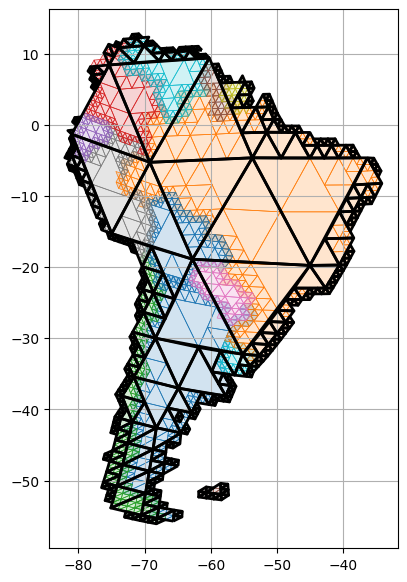

In [7]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 7))
ax.grid(True)

continent.plot(ax=ax, trixels=True, boundary=False, column='name', zorder=0, linewidth=2, alpha=0.2)
continent.plot(ax=ax, trixels=True, boundary=True, column='name', zorder=0, linewidth=0.5)

df = starepandas.STAREDataFrame(sids=[sids2], add_trixels=True)
df.plot(ax=ax, trixels=True, boundary=True, color='black', zorder=2, linewidth=2)

#plt.savefig('dissolve.png')

## High level functions

In [8]:
west = world[world['continent'].isin(['Europe', 'North America'])]
west = starepandas.STAREDataFrame(west, add_sids=True, level=4, add_trixels=False)

In [16]:
west.stare_dissolve(by='continent', aggfunc='first', geom=False)

,sids,pop_est,name,iso_a3,gdp_md_est
continent,,,,,
Europe,"[648518346341351428, 900719925474099204, 10448...",144373535.0,Russia,RUS,1699876
North America,"[1170935903116328964, 1173187702930014212, 117...",37589262.0,Canada,CAN,1736425


In [15]:
# We have to drop the sids column
west.drop('sids', axis=1).dissolve(by='continent', aggfunc='sum')

,geometry,pop_est,name,iso_a3,gdp_md_est
continent,,,,,
Europe,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",745412452.0,RussiaNorwayFranceSwedenBelarusUkrainePolandAu...,RUSNORFRASWEBLRUKRPOLAUTHUNMDAROULTULVAESTDEUB...,21587850
North America,"MULTIPOLYGON (((-155.22217 19.23972, -155.5421...",583756036.0,CanadaUnited States of AmericaHaitiDominican R...,CANUSAHTIDOMBHSGRLMEXPANCRINICHNDSLVGTMBLZPRIJ...,25075988


## Multiprocessing

### By continent

In [17]:
start = datetime.datetime.now()
west.stare_dissolve(by='continent', geom=False, num_workers=1)
print(datetime.datetime.now() - start)

0:00:13.544795


In [18]:
start = datetime.datetime.now()
west.stare_dissolve(by='continent', geom=False, num_workers=4)
print(datetime.datetime.now() - start)

0:00:09.751718


In [19]:
trixels = west.make_trixels(num_workers=4, wrap_lon=False)
trixels = starepandas.split_antimeridian_series(trixels, drop=True)
west.set_trixels(trixels, inplace=True)

/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, 

<Axes: >

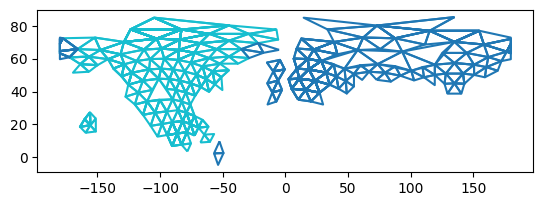

In [21]:
west.reset_index().plot(column='continent')